Background for loan default:
https://www.investopedia.com/terms/d/default2.asp

# Capstone - Loan Status Prediction Data Analysis

**Goal**: Build machine learning model(s) to predict loan status as target: if a loan will be charged-off (0), or stay current/are paid off (1). 

(1827125, 145)

Remove mostly NaN attributes

Q: What factor is associated with not paying loan off?
- social credit
- networth
- debt>networth(saving and checking, cash on hand)
- past history of not paying off
- age (risk higher if younger)


https://www.wellsfargo.com/financial-education/credit-management/calculate-credit-score/#:~:text=This%20is%20based%20on%20the,if%20you%20pay%20on%20time
- 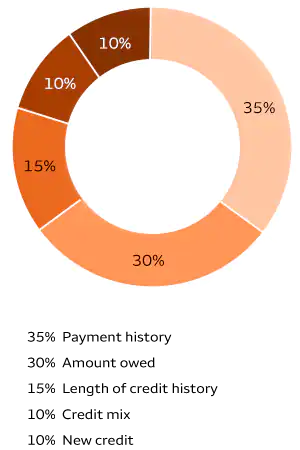

## Import packages

In [1]:
# Install packages
# import sys
# !{sys.executable} -m pip install kneed

# Get path 
import os
from pathlib import Path # get path

# Data wrangling
import pandas as pd
import numpy as np 

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot # qqplot for data normality test

# Statistical testing
import scipy.stats as stats


# Reporting
from pandas_profiling import ProfileReport


# PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA

#ML model building

# Logistic regression
from sklearn.metrics import classification_report

# Decision Tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from dmba import plotDecisionTree, textDecisionTree # tree visualization






import pydotplus


no display found. Using non-interactive Agg backend


## Load dataset

In [2]:
# load dataset
data_path = Path('.').resolve().parents[1] / 'train_data.csv'
train = pd.read_csv(data_path)

/var/folders/d5/0rs5hy6j79776c7g000ncxbm0000gn/T/ipykernel_66026/2918884660.py:3: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(data_path)


In [3]:
train.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,10000,10000,10000.0,36 months,8.81,317.12,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,10000,10000,10000.0,60 months,27.27,306.97,E,E5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,4800,4800,4800.0,36 months,16.91,170.92,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,35000,35000,35000.0,36 months,14.47,1204.23,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,16000,16000,15975.0,60 months,10.08,340.59,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.shape

(1827125, 145)

In [5]:
train.columns.tolist()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

Get rid of attributes only has fewer than 10% data 

In [6]:
na_tally = train.isna().sum().sort_values(ascending = False)

In [7]:
# list of >90% data missing 
na_tally[na_tally>train.shape[0]*0.9]

id                                            1827125
url                                           1827125
member_id                                     1827125
orig_projected_additional_accrued_interest    1822116
hardship_length                               1821000
hardship_reason                               1821000
hardship_status                               1821000
deferral_term                                 1821000
hardship_amount                               1821000
hardship_start_date                           1821000
hardship_end_date                             1821000
payment_plan_start_date                       1821000
hardship_dpd                                  1821000
hardship_loan_status                          1821000
hardship_payoff_balance_amount                1821000
hardship_last_payment_amount                  1821000
hardship_type                                 1821000
debt_settlement_flag_date                     1810175
settlement_status           

## Create modified Training dataset for model building - `trn`
1. remove >90% missing value columns
2. create dummy variable for target variable: 0='charged off', 1='Fully paid' or 'Current'

Paid off event rate is: 0.9269201614558391


In [8]:
trn = train.copy().drop(columns=na_tally[na_tally>train.shape[0]*0.9].index)

In [9]:
###### optional to run #########
# sample a 3_pct dataset to investigate 

# trn_sample_3pct = trn.sample(n = int(trn.shape[0]*0.03), replace = False, random_state=2) # 91356
# trn_sample_3pct.to_csv('trn_sample_3pct.csv')  

In [10]:
# target variable and transformation
print(trn['loan_status'].unique())

trn['loan_status_dv'] = [1 if loan_status=='Fully Paid'or loan_status=='Current' else 0 for loan_status in trn['loan_status']]
print("Paid off event rate is: {}".format(trn['loan_status_dv'].mean()))

['Charged Off' 'Current' 'Fully Paid']
Paid off event rate is: 0.9269201614558391


In [11]:
trn['loan_status'].value_counts()

Fully Paid     865468
Current        828131
Charged Off    133526
Name: loan_status, dtype: int64

In [12]:
trn.shape

(1827125, 108)

In [13]:
trn_coln = trn.columns
trn_coln.tolist()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_ba

In [14]:
trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827125 entries, 0 to 1827124
Columns: 108 entries, loan_amnt to loan_status_dv
dtypes: float64(80), int64(5), object(23)
memory usage: 1.5+ GB


# Exploratory data analysis  

Remove (NEED UPDATEEEEEEE): policy_code, verification_status, pymnt_plan, initial_list_status, application_type, hardship_flag, disbursement_method, funded_amnt, funded_amnt_inv, out_prncp_inv, total_pymnt_inv


Int type feature to train: loan_amnt, revol_bal


In [15]:
profile = ProfileReport(trn, minimal=True, title="Loans trn Profiling Report")
profile.to_file("trn_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# check NAs
trn.isna().sum().sort_values(ascending=False).head(38)

mths_since_last_record            1532158
mths_since_recent_bc_dlq          1396890
mths_since_last_major_derog       1346127
mths_since_recent_revol_delinq    1216894
next_pymnt_d                       998994
mths_since_last_delinq             932516
il_util                            815757
mths_since_rcnt_il                 679739
all_util                           642907
open_acc_6m                        642717
inq_last_12m                       642717
total_cu_tl                        642717
total_bal_il                       642716
open_rv_12m                        642716
open_il_24m                        642716
open_act_il                        642716
open_rv_24m                        642716
max_bal_bc                         642716
inq_fi                             642716
open_il_12m                        642716
mths_since_recent_inq              206528
emp_title                          134953
emp_length                         119754
num_tl_120dpd_2m                  

## Potential critical features

Some critical:


`loan_amnt`: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

`int_rate`: Interest Rate on the loan

`grade`: Assigned loan grade

`term`: The number of payments on the loan. Values are in months and can be either 36 or 60.

`emp_length`: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

`annual_inc`: The self-reported annual income provided by the borrower during registration.

`dti`: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested loan, divided by the borrower’s self-reported monthly income.

`mths_since_recent_inq`: Months since most recent inquiry.

`revol_util`: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

`bc_open_to_buy`: Total open to buy on revolving bankcards.

`bc_util`: Ratio of total current balance to high credit/credit limit for all bankcard accounts.

`num_op_rev_tl`: Number of open revolving accounts

...

In [17]:
trn[['loan_amnt', 'int_rate', 'grade', 'term', 'emp_length', 'annual_inc', 'dti',
    'mths_since_recent_inq', 'revol_util', 'bc_open_to_buy', 'bc_util', 'num_op_rev_tl']].describe()

,loan_amnt,int_rate,annual_inc,dti,mths_since_recent_inq,revol_util,bc_open_to_buy,bc_util,num_op_rev_tl
count,1.827125e+06,1.827125e+06,1.827125e+06,1.825674e+06,1.620597e+06,1.825711e+06,1.806682e+06,1.805771e+06,1.827125e+06
mean,1.510492e+04,1.292467e+01,7.879205e+04,1.889208e+01,7.090876e+00,4.995529e+01,1.167344e+04,5.743015e+01,8.233844e+00
std,9.232365e+03,4.797679e+00,1.207525e+05,1.444896e+01,5.979832e+00,2.463651e+01,1.685201e+04,2.859107e+01,4.688064e+00
min,1.000000e+03,5.310000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,9.440000e+00,4.700000e+04,1.193000e+01,2.000000e+00,3.110000e+01,1.791000e+03,3.480000e+01,5.000000e+00
50%,1.300000e+04,1.249000e+01,6.500000e+04,1.786000e+01,6.000000e+00,4.970000e+01,5.629000e+03,5.950000e+01,7.000000e+00
75%,2.000000e+04,1.561000e+01,9.500000e+04,2.456000e+01,1.100000e+01,6.890000e+01,1.459900e+04,8.260000e+01,1.000000e+01
max,4.000000e+04,3.099000e+01,1.100000e+08,9.990000e+02,2.500000e+01,8.923000e+02,7.111400e+05,3.396000e+02,9.100000e+01


##  Feature understanding & selection
 
1. ~policy_code~ 
2. ~verification_status~
3. ~pymnt_plan~
4. ~initial_list_status~
5. ~application_type~
6. ~hardship_flag~
7. ~disbursement_method~
8. ~funded_amnt~  
10. All Invs - ~funded_amnt_inv~, ~out_prncp_inv~, ~total_pymnt_inv~



### Column types

In [18]:
col_types = trn.dtypes.to_frame('dtypes').reset_index()
print(col_types['dtypes'].value_counts())

float64    80
object     23
int64       5
Name: dtypes, dtype: int64


In [19]:
print(col_types[col_types['dtypes']=='int64'])
print(col_types[col_types['dtypes']=='float64'])
print(col_types[col_types['dtypes']=='O']['index']) # object types may affect model training

              index dtypes
0         loan_amnt  int64
1       funded_amnt  int64
28        revol_bal  int64
47      policy_code  int64
107  loan_status_dv  int64
                          index   dtypes
2               funded_amnt_inv  float64
4                      int_rate  float64
5                   installment  float64
11                   annual_inc  float64
20                          dti  float64
..                          ...      ...
99                    tax_liens  float64
100             tot_hi_cred_lim  float64
101           total_bal_ex_mort  float64
102              total_bc_limit  float64
103  total_il_high_credit_limit  float64

[80 rows x 2 columns]
3                      term
6                     grade
7                 sub_grade
8                 emp_title
9                emp_length
10           home_ownership
12      verification_status
13                  issue_d
14              loan_status
15               pymnt_plan
16                  purpose
17             

### Investigate int and float features

Remove `policy_code` due to one unique value in entire dataset

Remove due to high correlations:
`funded_amnt`, `funded_amnt_inv`, `out_prncp_inv`, `total_pymnt_inv`

Some float and int maybe categorical

#### Int and float summaries

In [20]:
coln_int = col_types[col_types['dtypes']=='int64']['index']
for col in trn[coln_int]:
    print(trn[coln_int][col].unique())

[10000  4800 35000 ... 36075 36100 35125]
[10000  4800 35000 ... 36075 36100 35125]
[ 10494   3193   2809 ...  87844 110143  64696]
[1]
[0 1]


In [21]:
coln_float = col_types[col_types['dtypes']=='float64']['index']
col_float_unique = []
for col in trn[coln_float]:
    col_float_unique.append(trn[coln_float][col].unique())
# col_float_unique

In [22]:
coln_float_counts = coln_float.to_frame()
coln_float_counts['values'] = col_float_unique
coln_float_counts
# coln_float_counts.to_csv('coln_float_counts.csv')  

,index,values
2,funded_amnt_inv,"[10000.0, 4800.0, 35000.0, 15975.0, 7500.0, 34..."
4,int_rate,"[8.81, 27.27, 16.91, 14.47, 10.08, 13.56, 15.0..."
5,installment,"[317.12, 306.97, 170.92, 1204.23, 340.59, 267...."
11,annual_inc,"[56000.0, 70000.0, 111000.0, 95000.0, 45000.0,..."
20,dti,"[20.53, 11.37, 13.35, 11.61, 25.52, 0.21, 10.3..."
...,...,...
99,tax_liens,"[0.0, 1.0, 2.0, 4.0, 3.0, 5.0, 7.0, 8.0, 6.0, ..."
100,tot_hi_cred_lim,"[327790.0, 25493.0, 41728.0, 501756.0, 85395.0..."
101,total_bal_ex_mort,"[30771.0, 23289.0, 32060.0, 56195.0, 28179.0, ..."
102,total_bc_limit,"[12000.0, 1800.0, 7100.0, 0.0, 31100.0, 3500.0..."


In [88]:
trn[coln_int].corr()

,loan_amnt,funded_amnt,revol_bal,policy_code,loan_status_dv
loan_amnt,1.000000,0.999999,0.321272,NaN,-0.016071
funded_amnt,0.999999,1.000000,0.321272,NaN,-0.016071
revol_bal,0.321272,0.321272,1.000000,NaN,0.017157
policy_code,NaN,NaN,NaN,NaN,NaN
loan_status_dv,-0.016071,-0.016071,0.017157,NaN,1.000000


#### loan_amnt and funded_amnt - remove funded_amnt 
Remove funded_amnt and funded_amnt_inv. >0.999999 correlation with loan_amnt

In [23]:
plt.scatter(trn['loan_amnt'],trn['funded_amnt_inv'])

In [24]:
plt.scatter(trn['loan_amnt'],trn['funded_amnt'])

In [25]:
plt.scatter(trn['funded_amnt'],trn['funded_amnt_inv'])

In [26]:
trn[['loan_amnt','funded_amnt','funded_amnt_inv']].corr()

,loan_amnt,funded_amnt,funded_amnt_inv
loan_amnt,1.000000,0.999999,0.999994
funded_amnt,0.999999,1.000000,0.999995
funded_amnt_inv,0.999994,0.999995,1.000000


#### Feature with invs - remove invs 
Very high correlation between out_prncp,total_pymnt, funded_amnt and their _inv counterparts

In [62]:
print(trn[['out_prncp','out_prncp_inv']].corr())
print(trn[['total_pymnt','total_pymnt_inv']].corr())
print(trn[['funded_amnt','funded_amnt_inv']].corr())

               out_prncp  out_prncp_inv
out_prncp       1.000000       0.999999
out_prncp_inv   0.999999       1.000000
                 total_pymnt  total_pymnt_inv
total_pymnt         1.000000         0.999996
total_pymnt_inv     0.999996         1.000000
                 funded_amnt  funded_amnt_inv
funded_amnt         1.000000         0.999995
funded_amnt_inv     0.999995         1.000000


### Investigate object/categorical features that have few unique values
Use Chi-square to test significance. Cramer's V for strength of association (<0.1 weak association, >0.5 strong association)

Null hypothesis: There is no significant relationship between two categorical variables.

- term
- grade & sub_grade
- ~verification_status~
- ~pymnt_plan~
- ~initial_list_status~
- ~application_type~
- ~hardship_flag~
- ~disbursement_method~
- debt_settlement_flag

'term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'
       
Paid off (loan_status_dv=0) event rate is: 0.9269201614558391

In [27]:
coln_obj = col_types[col_types['dtypes']=='O']['index'] # object types may affect model training
trn[coln_obj];

In [28]:
coln_obj

3                      term
6                     grade
7                 sub_grade
8                 emp_title
9                emp_length
10           home_ownership
12      verification_status
13                  issue_d
14              loan_status
15               pymnt_plan
16                  purpose
17                    title
18                 zip_code
19               addr_state
22         earliest_cr_line
31      initial_list_status
41             last_pymnt_d
43             next_pymnt_d
44       last_credit_pull_d
48         application_type
104           hardship_flag
105     disbursement_method
106    debt_settlement_flag
Name: index, dtype: object

In [29]:
# check unique values in object columns
for col in trn[coln_obj]:
    print(trn[coln_obj][col].unique())

[' 36 months' ' 60 months']
['A' 'E' 'C' 'B' 'D' 'G' 'F']
['A5' 'E5' 'C5' 'C2' 'B1' 'C1' 'C3' 'B2' 'D2' 'D3' 'B3' 'A2' 'E3' 'G1'
 'B4' 'D4' 'B5' 'E2' 'E4' 'D1' 'A4' 'D5' 'C4' 'A1' 'F2' 'F1' 'E1' 'F4'
 'F5' 'A3' 'G2' 'F3' 'G4' 'G3' 'G5']
[nan 'CNC Robotic Welder' 'Information Tech II' ... 'Acft mechanic'
 'Content Review ' 'BABYSITTER']
[nan '10+ years' '1 year' '< 1 year' '4 years' '6 years' '3 years'
 '2 years' '7 years' '8 years' '5 years' '9 years']
['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE']
['Verified' 'Source Verified' 'Not Verified']
['Nov-2018' 'Oct-2018' 'Sep-2018' 'Aug-2018' 'Jul-2018' 'Jun-2018'
 'May-2018' 'Apr-2018' 'Mar-2018' 'Feb-2018' 'Jan-2018' 'Sep-2016'
 'Aug-2016' 'Jul-2016' 'Jun-2016' 'May-2016' 'Apr-2016' 'Mar-2016'
 'Feb-2016' 'Jan-2016' 'Dec-2016' 'Nov-2016' 'Oct-2016' 'Dec-2015'
 'Nov-2015' 'Oct-2015' 'Sep-2015' 'Aug-2015' 'Jul-2015' 'Jun-2015'
 'May-2015' 'Apr-2015' 'Mar-2015' 'Feb-2015' 'Jan-2015' 'Mar-2017'
 'Feb-2017' 'Jan-2017' 'Sep-2017' 'Aug-2017' 'Jul-2017' 

['AZ' 'IL' 'VA' 'TX' 'MN' 'NC' 'ME' 'SC' 'MA' 'MI' 'DE' 'OK' 'CA' 'LA'
 'NJ' 'TN' 'MD' 'WA' 'NE' 'UT' 'PA' 'FL' 'KS' 'IN' 'NY' 'MO' 'GA' 'KY'
 'NV' 'ID' 'OH' 'AL' 'MS' 'CO' 'WY' 'CT' 'WI' 'HI' 'VT' 'DC' 'NM' 'WV'
 'OR' 'NH' 'AR' 'RI' 'MT' 'ND' 'SD' 'AK' 'IA']
['Apr-2011' 'Nov-2008' 'Jun-2006' 'Jun-2005' 'Feb-2013' 'Aug-2003'
 'Feb-2005' 'Oct-2007' 'Aug-2012' 'Sep-1993' 'Nov-2000' 'Sep-2007'
 'Dec-2000' 'Dec-1989' 'Oct-2012' 'Jul-1995' 'Dec-1999' 'Aug-2001'
 'Aug-1990' 'Jan-2012' 'Mar-2006' 'Nov-2005' 'Aug-2015' 'Jan-2010'
 'Apr-2008' 'Aug-2005' 'Oct-2008' 'Sep-2002' 'Oct-2004' 'Apr-1988'
 'Dec-2005' 'Apr-2006' 'Feb-2007' 'Sep-2008' 'Jun-1999' 'Oct-1992'
 'Jan-1996' 'Jul-2008' 'Nov-2001' 'Jun-2003' 'Jan-1977' 'Oct-2009'
 'Jul-2013' 'Oct-1985' 'Jul-1989' 'Nov-1980' 'Jul-2010' 'May-1978'
 'Aug-2011' 'Jun-1995' 'Sep-2000' 'May-2006' 'Aug-2009' 'Dec-2013'
 'Sep-2006' 'Jun-1977' 'Dec-1993' 'May-2002' 'Nov-2006' 'Oct-2014'
 'Apr-2009' 'Oct-1996' 'Dec-2003' 'Oct-2003' 'Aug-2008' 'Dec-2010'
 'M

['w' 'f']
[nan 'Dec-2018' 'Nov-2018' 'Jan-2019' 'Oct-2018' 'Sep-2018' 'Aug-2018'
 'Feb-2019' 'Jul-2018' 'Jun-2018' 'May-2018' 'Apr-2018' 'Mar-2018'
 'Feb-2018' 'Jan-2018' 'Nov-2017' 'May-2017' 'Aug-2017' 'Jun-2017'
 'Apr-2017' 'Mar-2017' 'Sep-2017' 'Dec-2016' 'Jan-2017' 'Jul-2017'
 'Oct-2017' 'Dec-2017' 'Nov-2016' 'Feb-2017' 'Oct-2016' 'Sep-2016'
 'Aug-2016' 'Jul-2016' 'Jun-2016' 'May-2016' 'Apr-2016' 'Mar-2016'
 'Feb-2016' 'Jan-2016' 'Dec-2015' 'Nov-2015' 'Oct-2015' 'Sep-2015'
 'Aug-2015' 'Jul-2015' 'Jun-2015' 'May-2015' 'Apr-2015' 'Mar-2015'
 'Feb-2015' 'Dec-2014' 'Mar-2014' 'Jul-2014' 'May-2014' 'Jan-2015'
 'Nov-2014' 'Aug-2014' 'Oct-2014' 'Sep-2014' 'Apr-2014' 'Jun-2014'
 'Feb-2014' 'Jan-2014' 'Dec-2013' 'Nov-2013' 'Oct-2013' 'Sep-2013'
 'Aug-2013' 'Jul-2013' 'Jun-2013' 'May-2013' 'Apr-2013' 'Mar-2013'
 'Feb-2013']
[nan 'Mar-2019' 'Feb-2019' 'Apr-2019' 'Dec-2018' 'Sep-2018' 'Aug-2018'
 'Feb-2018']
['Jan-2019' 'Feb-2019' 'Nov-2018' 'Dec-2018' 'Oct-2018' 'Sep-2018'
 'Aug-2018' 'Jul-2

#### term
may remove

In [30]:
trn[['term','loan_status_dv']].value_counts(normalize=True)

term        loan_status_dv
 36 months  1                 0.671751
 60 months  1                 0.255169
 36 months  0                 0.044452
 60 months  0                 0.028627
dtype: float64

In [31]:
data = pd.crosstab(trn['term'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 8255.671704129067
p-value: 0.0
Cramer_V: 0.06722133680220137


#### grade & sub_grade
top default grade loan C, D, B; stronger association in sub_grade

In [32]:
trn[['loan_status_dv','grade']].value_counts(normalize=True).sort_index()

loan_status_dv  grade
0               A        0.003694
                B        0.013987
                C        0.023561
                D        0.016711
                E        0.009927
                F        0.003937
                G        0.001264
1               A        0.195649
                B        0.284433
                C        0.264657
                D        0.121461
                E        0.045292
                F        0.012139
                G        0.003288
dtype: float64

In [33]:
trn[['loan_status_dv', 'sub_grade']].value_counts(normalize=True).sort_values(
    ascending=False).to_frame().reset_index().sort_values(['loan_status_dv', 0], ascending=False).tail(40)

,loan_status_dv,sub_grade,0
51,1,G1,0.001184
56,1,G2,0.000707
58,1,G3,0.000553
61,1,G4,0.000443
63,1,G5,0.000401
25,0,C4,0.005143
26,0,C5,0.004881
27,0,C3,0.004671
28,0,C2,0.004477
29,0,C1,0.004388


In [34]:
data = pd.crosstab(trn['grade'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 65545.81092960325
p-value: 0.0
Cramer_V: 0.18940364844059815


In [35]:
data = pd.crosstab(trn['sub_grade'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 67869.88355902435
p-value: 0.0
Cramer_V: 0.1927322635693128


#### verification_status
Remove

In [36]:
trn[['verification_status','loan_status_dv']].value_counts(normalize=True).sort_index()

verification_status  loan_status_dv
Not Verified         0                 0.015720
                     1                 0.317170
Source Verified      0                 0.030374
                     1                 0.367329
Verified             0                 0.026986
                     1                 0.242421
dtype: float64

In [37]:
data = pd.crosstab(trn['verification_status'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 11450.811364192554
p-value: 0.0
Cramer_V: 0.07916514292617349


#### pymnt_plan
Remove, only 0.0002% people (3.65) on payment plan, too few samples, chi-square test p-value = 1.0, Cramer's V weak

In [38]:
trn[['pymnt_plan','loan_status_dv']].value_counts().sort_index()

pymnt_plan  loan_status_dv
n           0                  133526
            1                 1693596
y           1                       3
dtype: int64

In [39]:
data = pd.crosstab(trn['pymnt_plan'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 0.0
p-value: 1.0
Cramer_V: 0.0003597944660247935


#### initial_list_status
Remove

In [40]:
trn[['initial_list_status','loan_status_dv']].value_counts(normalize=True)

initial_list_status  loan_status_dv
w                    1                 0.665610
f                    1                 0.261310
w                    0                 0.045061
f                    0                 0.028019
dtype: float64

In [41]:
data = pd.crosstab(trn['initial_list_status'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 6199.4102537662275
p-value: 0.0
Cramer_V: 0.05825166540995237


#### application_type
Remove

In [42]:
trn[['application_type','loan_status_dv']].value_counts(normalize=True)

application_type  loan_status_dv
Individual        1                 0.872361
                  0                 0.071434
Joint App         1                 0.054559
                  0                 0.001646
dtype: float64

In [43]:
data = pd.crosstab(trn['application_type'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 3079.355242469879
p-value: 0.0
Cramer_V: 0.04105764713425524


#### hardship_flag
Remove. hardship_flag only has 9 'Y' record paid-off

In [44]:
trn[['hardship_flag','loan_status_dv']].value_counts()

hardship_flag  loan_status_dv
N              1                 1693590
               0                  133526
Y              1                       9
dtype: int64

In [45]:
data = pd.crosstab(trn['hardship_flag'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 0.040802357461754826
p-value: 0.8399199026518551
Cramer_V: 0.0006231833186590913


#### disbursement_method
Remove

In [46]:
trn[['disbursement_method','loan_status_dv']].value_counts(normalize=True)

disbursement_method  loan_status_dv
Cash                 1                 0.889524
                     0                 0.072716
DirectPay            1                 0.037396
                     0                 0.000364
dtype: float64

In [47]:
data = pd.crosstab(trn['disbursement_method'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 4259.089020684353
p-value: 0.0
Cramer_V: 0.048286290564561414


#### debt_settlement_flag
Def.: Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.

Expecting only Y in charged-off (0) category. 23 records maybe misclassified? 

may keep

In [48]:
trn[['debt_settlement_flag','loan_status_dv']].value_counts()

debt_settlement_flag  loan_status_dv
N                     1                 1693576
                      0                  116599
Y                     0                   16927
                      1                      23
dtype: int64

In [49]:
data = pd.crosstab(trn['debt_settlement_flag'],trn['loan_status_dv'])
print(f"Chi_square statistic: {stats.chi2_contingency(data)[0]}")
print(f"p-value: {stats.chi2_contingency(data)[1]}")

# [2]: degree of freedom. [3]: expected contingency table

X2 = stats.chi2_contingency(data,correction=False)[0]
N = np.sum(np.sum(data))
minimum_dimension = min(data.shape)-1
Cramer_V = np.sqrt((X2/N) / minimum_dimension)

print(f'Cramer_V: {Cramer_V}')

Chi_square statistic: 216352.5380307116
p-value: 0.0
Cramer_V: 0.34412062953067346


## Correlation matrix 
Remove correlation >0.95

'loan_amnt','installment' corr: 0.945845

'num_sats','open_acc' corr: 0.998966

'total_pymnt','total_rec_prncp' corr: 0.970633

'recoveries','collection_recovery_fee' corr: 0.976459	

'tot_hi_cred_lim','tot_cur_bal' corr: 0.975565

'total_bal_il', 'total_il_high_credit_limit' corr: 0.951876

'num_rev_tl_bal_gt_0','num_actv_rev_tl' corr: 0.983753

In [106]:
# drop features determined in section above and target variable, object features drop automatically
trn_featuredrop = trn.drop(columns=['loan_status_dv','policy_code', 'verification_status', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'out_prncp_inv', 'total_pymnt_inv'])
print(f'Number of features in correlation matrix: {len(trn_featuredrop.corr().columns)}')
trn_featuredrop.corr()
#trn_featuredrop.corr().to_csv('feature_correlation_intfloat.csv') # Pearson

/var/folders/d5/0rs5hy6j79776c7g000ncxbm0000gn/T/ipykernel_66026/3522312297.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(f'Number of features in correlation matrix: {len(trn_featuredrop.corr().columns)}')


Number of features in correlation matrix: 79


/var/folders/d5/0rs5hy6j79776c7g000ncxbm0000gn/T/ipykernel_66026/3522312297.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  trn_featuredrop.corr()


,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
loan_amnt,1.000000,0.082341,0.945845,0.185775,0.041013,-0.013667,-0.025355,-0.009848,0.016203,0.179580,...,-0.024684,-0.029042,0.092727,0.023301,-0.089215,0.005392,0.337112,0.276982,0.375120,0.207718
int_rate,0.082341,1.000000,0.107159,-0.050220,0.122082,0.058910,0.190361,-0.045079,-0.015488,-0.016895,...,0.033986,0.178248,-0.082637,0.273078,0.058372,0.014725,-0.124277,0.005292,-0.242831,-0.003028
installment,0.945845,0.107159,1.000000,0.179339,0.042174,-0.001969,0.000396,-0.019527,0.000866,0.168642,...,-0.018145,-0.006884,0.073559,0.045915,-0.080206,0.012494,0.301746,0.259743,0.339165,0.190761
annual_inc,0.185775,-0.050220,0.179339,1.000000,-0.078736,0.023904,0.020290,-0.029375,-0.055724,0.088342,...,0.003282,0.032851,-0.004040,-0.001499,-0.027034,0.023081,0.250865,0.196331,0.168850,0.166723
dti,0.041013,0.122082,0.042174,-0.078736,1.000000,-0.013665,-0.007695,0.014013,0.059119,0.180550,...,-0.013028,0.043529,0.065196,0.102471,-0.016256,-0.022274,0.032150,0.192829,0.038091,0.219001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tax_liens,0.005392,0.014725,0.012494,0.023081,-0.022274,0.010692,0.017245,0.003765,-0.305589,-0.007073,...,0.002258,0.017837,-0.032971,-0.008620,0.031783,1.000000,-0.000945,-0.001974,-0.027011,0.004670
tot_hi_cred_lim,0.337112,-0.124277,0.301746,0.250865,0.032150,0.055235,0.032367,-0.077674,-0.001119,0.299260,...,0.003130,0.103422,0.026158,-0.007989,-0.102024,-0.000945,1.000000,0.519901,0.405493,0.424652
total_bal_ex_mort,0.276982,0.005292,0.259743,0.196331,0.192829,0.026393,0.038615,-0.020482,-0.012518,0.405879,...,0.013683,0.119146,0.062813,0.072972,-0.076108,-0.001974,0.519901,1.000000,0.297139,0.876985
total_bc_limit,0.375120,-0.242831,0.339165,0.168850,0.038091,-0.079087,-0.001718,0.005908,0.022637,0.387834,...,-0.059552,0.053789,0.218477,-0.211977,-0.146394,-0.027011,0.405493,0.297139,1.000000,0.143123


### > 0.8 correlation 

'num_sats','open_acc' corr: 0.9989

'out_prncp','out_prncp_inv' corr: 0.999 - __remove out_prncp_inv__

'total_pymnt','total_pymnt_inv' corr: 0.999 - __remove total_pymnt_inv__

'total_pymnt','total_rec_prncp' corr: 0.999 - __remove total_rec_prncp__

'num_rev_tl_bal_gt_0','num_actv_rev_tl' corr: 0.984

'tot_hi_cred_lim','tot_cur_bal' corr: 0.976

'total_pymnt_inv','total_rec_prncp' corr: 0.971

'recoveries','collection_recovery_fee' corr: 0.976

'funded_amnt' vs 'installment' corr: 0.946

----------

'acc_now_delinq','num_tl_30dpd' corr: 0.801

'tot_cur_bal','avg_cur_bal' corr: 0.827

'total_bal_ex_mort','total_bal_il' corr: 0.89997

'total_il_high_credit_limit','total_bal_il' corr: 0.952

'open_rv_12m','num_tl_op_past_12m' corr: 0.843

'open_rv_24m','acc_open_past_24mths' corr: 0.849

'total_bc_limit','bc_open_to_buy' corr: 0.846

'percent_bc_gt_75','bc_util' corr: 0.846

'mths_since_recent_revol_delinq','mths_since_recent_bc_dlq' corr: 0.891

'num_rev_tl_bal_gt_0','num_actv_bc_tl' corr: 0.816

'num_actv_rev_tl','num_actv_bc_tl' corr: 0.823

'num_bc_sats','num_actv_bc_tl' corr: 0.837

'num_rev_accts','num_bc_tl' corr: 0.840

'num_rev_tl_bal_gt_0','num_op_rev_tl' corr: 0.802

'num_sats','num_op_rev_tl' corr: 0.837

'total_il_high_credit_limit','total_bal_ex_mort' corr: 0.877

'mths_since_recent_revol_delinq','mths_since_last_delinq' corr: 0.864

'num_op_rev_tl','open_acc' corr: 0.838

'bc_util','revol_util' corr: 0.870


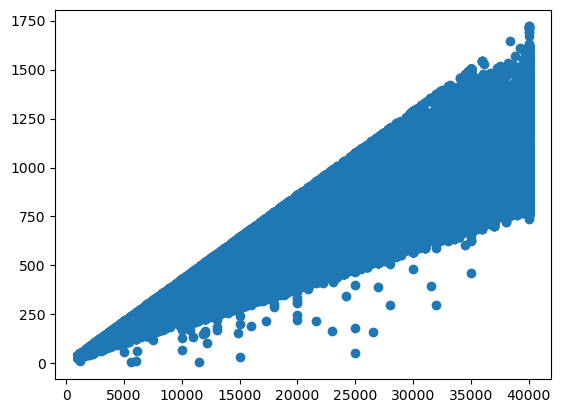

In [105]:
%matplotlib inline
plt.scatter(trn['loan_amnt'],trn['installment'])

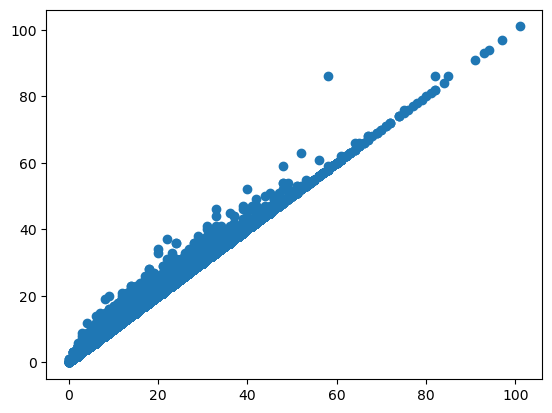

In [107]:
%matplotlib inline
plt.scatter(trn['num_sats'],trn['open_acc'])

In [53]:
plt.scatter(trn['num_rev_tl_bal_gt_0'],trn['num_actv_rev_tl'])

In [54]:
plt.scatter(trn['total_pymnt'],trn['total_rec_prncp'])

## Time data vs loan status

In [55]:
time_coln = ['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d']

trn_date=pd.to_datetime(trn[time_coln].stack(),infer_datetime_format=True).unstack()
trn_date

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d
0,2018-11-01,2011-04-01,NaT,NaT,2019-01-01
1,2018-11-01,2008-11-01,2018-12-01,NaT,2019-02-01
2,2018-11-01,2006-06-01,2018-12-01,NaT,2018-11-01
3,2018-11-01,2005-06-01,2018-12-01,NaT,2019-02-01
4,2018-11-01,2013-02-01,2018-12-01,NaT,2019-02-01
...,...,...,...,...,...
1827120,2017-10-01,1996-08-01,2019-02-01,2019-03-01,2019-02-01
1827121,2017-10-01,2004-01-01,2019-02-01,2019-03-01,2019-02-01
1827122,2017-10-01,1995-02-01,2019-02-01,2019-03-01,2019-02-01
1827123,2017-10-01,2003-07-01,2019-02-01,2019-03-01,2019-02-01


In [56]:
trn[time_coln]

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d
0,Nov-2018,Apr-2011,NaN,NaN,Jan-2019
1,Nov-2018,Nov-2008,Dec-2018,NaN,Feb-2019
2,Nov-2018,Jun-2006,Dec-2018,NaN,Nov-2018
3,Nov-2018,Jun-2005,Dec-2018,NaN,Feb-2019
4,Nov-2018,Feb-2013,Dec-2018,NaN,Feb-2019
...,...,...,...,...,...
1827120,Oct-2017,Aug-1996,Feb-2019,Mar-2019,Feb-2019
1827121,Oct-2017,Jan-2004,Feb-2019,Mar-2019,Feb-2019
1827122,Oct-2017,Feb-1995,Feb-2019,Mar-2019,Feb-2019
1827123,Oct-2017,Jul-2003,Feb-2019,Mar-2019,Feb-2019


In [57]:
trn[].unique

SyntaxError: invalid syntax (1749565322.py, line 1)

In [ ]:
trn[time_coln].describe()

In [ ]:
plt.hist(trn_date['issue_d'],trn['loan_status_dv'])

In [ ]:
trn_date=pd.to_datetime(trn[time_coln].stack(),infer_datetime_format=True)
trn_date.dt.year.unstack()
trn_date.dt.month.unstack()

# PCA

The primary explanation for this is that the PCA, which involves dissecting the variance structure of the variable, is made to function better with numerical or continuous variables. PCA won't be effective with categorical variables since they lack a variance structure (they are not numerical

In [ ]:
# check NAs
trn.isna().sum().sort_values(ascending=False).head(38)

In [ ]:
# create list of features for PCA, target variables, remove object/categorical variables, months
trn_PCA_coln=trn.columns.tolist()
trn_PCA_coln=[i for i in trn_PCA_coln if i not in ['policy_code','loan_status_dv']+coln_obj.tolist()]

# check data with NaN
print(trn[trn_PCA_coln].isna().sum().sort_values(ascending=False).head(32))

# remove data with NaN
trn_PCA_coln=[i for i in trn_PCA_coln if i not in ['policy_code','loan_status_dv']+coln_obj.tolist()+trn[trn_PCA_coln].isna().sum().sort_values(ascending=False).head(32).index.tolist()]
trn_PCA_coln;

In [ ]:
np.array(trn_PCA_coln)

In [ ]:
trn[trn_PCA_coln].describe()

In [ ]:
# months
trn[['mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_bc', 'mths_since_last_major_derog',
    'mths_since_recent_revol_delinq', 'mths_since_last_delinq', 'mths_since_rcnt_il', 'mths_since_recent_inq', 'mo_sin_old_il_acct']].describe().T

mths_since_last_delinq	      The number of months since the borrower's last delinquency.

mths_since_last_major_derog	  Months since most recent 90-day or worse rating

mths_since_last_record	      The number of months since the last public record.

mths_since_rcnt_il	          Months since most recent installment accounts opened

mths_since_recent_bc	      Months since most recent bankcard account opened.

mths_since_recent_bc_dlq	  Months since most recent bankcard delinquency

mths_since_recent_inq	       Months since most recent inquiry.

mths_since_recent_revol_delinq	Months since most recent revolving delinquency

While you can use PCA on binary data (e.g. one-hot encoded data) that does not mean it is a good thing, or it will work very well.

In [ ]:
# process flow
features = trn_PCA_coln # exclude 'dv', 'loan_status'

# features
x = trn.loc[:, features].values

# target
y = trn.loc[:,['loan_status_dv']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)
n_samples = x.shape[0]


# set up PCA 
n_pc = 0.95 # variance preserved; number of features to reduce to. goal to get 95% of variance explained .
pca = PCA(n_components=n_pc)
principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents
            # , columns = ['pc_'+str(i+1) for i in range(n_pc)])

# calculate eigenvalues
# method 1
eigenvalues = pca.explained_variance_
plt.plot(eigenvalues)



In [ ]:


# plot incremental variance explained

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('incremental variance explained ')
plt.title('Incremental variance explained by PC')


# plot cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative variance explained by PC')


# Visualize data on different PCs to see if variation of perserved (patterns) or not

# Decision tree feature importance
https://towardsdatascience.com/feature-importance-in-decision-trees-e9450120b445

https://github.com/Eligijus112/gradient-boosting/blob/master/regression/feature_importance.ipynb

In [ ]:
# Loading the data
_cali_data = fetch_california_housing(as_frame=True)
X, y = _cali_data.data, _cali_data.target

# Droping the geo coordinate featuress
X = X.drop(columns=['Latitude', 'Longitude'])

# Droping the population feature; In real life modeling, this could be used as weight. 
# For educational and inference purposes, we drop it.
X = X.drop(columns=['Population'])

# Saving the feature names 
features = X.columns.tolist()


In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Train test split 

coln_nan = pd.DataFrame(trn.isna().sum().sort_values(ascending=False)).head(38).index.tolist()
X = trn.drop(columns=['loan_status','loan_status_dv']+coln_obj.tolist()+coln_nan, axis=1)

# drop target variable columns, columns with object, columns with missing values

y = trn['loan_status_dv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
features = X.columns.tolist()


# Defining the hyper parameters 
hps = {
    'max_depth': 3,
    'min_samples_split': 4,
    'random_state': 0
}

# Loading the tree object 
tree = DecisionTreeRegressor(**hps)

# Fitting on the training data 
tree.fit(X_train, y_train)

# Extracting the importances by sklearn 
importances_sk = tree.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

print(f"Feature importance by sklearn: {feature_importance_sk}")

In [ ]:
plt.figure(figsize=(20, 20))
plot_tree(tree, feature_names=features, filled=True)
plt.show()

In [ ]:
# Creating a dataframe with the feature importance by our method and the sklearn method
feature_importance_df = pd.DataFrame({
    "Feature": features,
    "Feature importance": [feature_importance_sk[feature] for feature in features]
}).sort_values('Feature importance', ascending=False)
feature_importance_df[feature_importance_df['Feature importance']!=0]